In [176]:
rm(list = ls())
options(scipen = 100, digits = 8)
library(readr)
library(dplyr)
library(ggplot2)
library(reshape2)
library(dse)
library(readxl)
library(zoo)
library(tseries)
library(xts)
library(imputeTS)
library(ggpubr)
library(corrplot)

In [177]:
# lag function
lagpad <- function(x, k = 1) {
  i <- is.vector(x)
  if (is.vector(x)) x <- matrix(x) else x <- matrix(x, nrow(x))
  if (k > 0) {
    x <- rbind(matrix(rep(NA, k * ncol(x)), ncol = ncol(x)), matrix(x[1:(nrow(x) - k), ], ncol = ncol(x)))
  } else {
    x <- rbind(matrix(x[(-k + 1):(nrow(x)), ], ncol = ncol(x)), matrix(rep(NA, -k * ncol(x)), ncol = ncol(x)))
  }
  if (i) x[1:length(x)] else x
}

## Load data

In [178]:
nat_gas_spot <- read_excel("data/NG_PRI_FUT_S1_D.xls", sheet = "Data 1", skip = 2) %>%
  rename("Natural_Gas" = 2)
crude_oil_spot <- read_excel("data/PET_PRI_SPT_S1_D.xls", sheet = "Data 1", skip = 2) %>%
  rename("Crude_Oil_WTI" = 2, "Crude_Oil_Europe_Brent" = 3)
gasoline <- read_excel("data/PET_PRI_SPT_S1_D.xls", sheet = "Data 2", skip = 2) %>%
  rename("NY_Gasoline" = 2, "Gulf_Gasoline" = 3)
heating_oil <- read_excel("data/PET_PRI_SPT_S1_D.xls", sheet = "Data 4", skip = 2) %>%
  rename("Heating_Oil" = 2)
diesel <- read_excel("data/PET_PRI_SPT_S1_D.xls", sheet = "Data 5", skip = 2) %>%
  select(-2, -3) %>%
  rename("Diesel" = 2)

### Group to dataframe and time-series form

In [179]:
dt <- nat_gas_spot %>%
  full_join(crude_oil_spot, by = "Date") %>%
  full_join(gasoline, by = "Date") %>%
  full_join(heating_oil, by = "Date") %>%
  full_join(diesel, by = "Date") %>%
  arrange(Date) %>%
  filter(Date >= "1997-01-07") %>%
  mutate(Date=as.Date(Date))

nat_gas_spot_ts <- xts(nat_gas_spot$Natural_Gas, frequency = 365, order.by = as.Date(nat_gas_spot$Date))
crude_oil_spot <- ts(crude_oil_spot[, 1:2], frequency = 7, start = as.Date("1997-01-07"), end = as.Date("2021-07-01"))
NY_Gasoline_ts <- ts(gasoline[, c(1, 2)], start = as.Date("1997-01-07"))
Gulf_Gasoline_ts <- ts(gasoline[, c(1, 3)], start = as.Date("1997-01-07"))
heating_oil_ts <- ts(heating_oil, start = as.Date("1997-01-07"))
diesel_ts <- ts(diesel, start = as.Date("1997-01-07"))
ts_list <- list(nat_gas_spot_ts, crude_oil_spot, NY_Gasoline_ts, Gulf_Gasoline_ts, heating_oil_ts, diesel_ts)

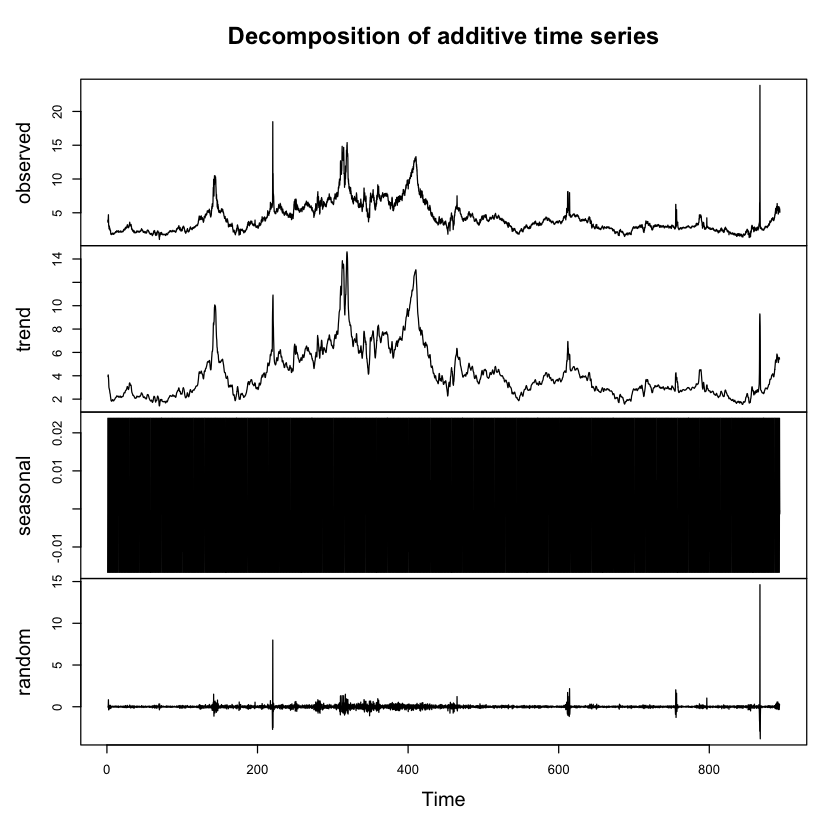

In [180]:
attr(nat_gas_spot_ts, "frequency") <- 7
nat_gas_spot_ts <- na.omit(nat_gas_spot_ts)
plot(decompose(as.ts(nat_gas_spot_ts))) 
# Dont know hot to use this decomposition, but might be a useful tool in the future.

### Removing NAs

In [181]:
colSums(is.na(dt))
nrow(dt) # about 2% NAs
aux <- dt[!complete.cases(dt), ]
head(aux)

Date            Natural_Gas          Crude_Oil_WTI 
                     0                    113                    126 
Crude_Oil_Europe_Brent            NY_Gasoline          Gulf_Gasoline 
                    64                    127                    131 
           Heating_Oil                 Diesel 
                   127                    127

[1] 6363

Date,Natural_Gas,Crude_Oil_WTI,Crude_Oil_Europe_Brent,NY_Gasoline,Gulf_Gasoline,Heating_Oil,Diesel
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1997-01-14,4.01,25.10,NA,0.648,0.639,0.694,0.740
1997-02-07,2.39,22.30,NA,0.614,0.613,0.623,0.835
1997-02-17,NA,NA,20.48,NA,NA,NA,NA
1997-03-07,1.89,21.35,NA,0.630,0.618,0.540,0.733
1997-03-28,NA,NA,18.53,NA,NA,NA,NA
1997-07-01,2.16,20.11,NA,0.557,0.572,0.545,0.579


We see that the Europe Brent crude oil benchmark is reported on days when the others arent, so we only use WTI.
Then we will delete rows filled with NAs.

In [182]:
dt <- dt %>% select(-Crude_Oil_Europe_Brent)
NA_dates <- dt %>%
  filter_at(vars(-Date), all_vars(is.na(.))) %>%
  pull(Date)
dt <- dt %>% filter(!Date %in% NA_dates)

aux <- dt[!complete.cases(dt), ]
aux[10:20, ]

print("Number of NAs in each column:")
colSums(is.na(aux))
print(paste("Number of rows in the dataframe:",nrow(dt)))
dt <- dt %>% mutate_all(~ replace(., is.na(.), mean(., na.rm = TRUE)))

Date,Natural_Gas,Crude_Oil_WTI,NY_Gasoline,Gulf_Gasoline,Heating_Oil,Diesel
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2005-09-29,NA,66.83,2.178,2.660,2.083,2.555
2005-09-30,NA,66.21,2.095,2.545,2.051,2.530
2005-10-03,NA,65.36,2.062,2.422,2.020,2.355
2005-10-04,NA,63.74,2.044,2.395,2.010,2.360
2005-10-05,NA,62.56,1.924,2.195,1.958,2.368
2005-10-06,NA,61.81,1.865,2.010,1.930,2.315
2010-02-05,5.61,71.15,1.894,NA,1.892,1.916
2012-06-14,2.20,83.83,2.708,NA,2.641,NA
2012-11-21,3.59,87.08,2.832,NA,3.064,3.129


[1] "Number of NAs in each column:"


Date   Natural_Gas Crude_Oil_WTI   NY_Gasoline Gulf_Gasoline 
            0            16            29            30            34 
  Heating_Oil        Diesel 
           30            30

[1] "Number of rows in the dataframe: 6266"


Data still not complete, mostly differs in the data sources (1st column vs rest). It might be best to treate the first and second source as separate, but there is only a few NAs, so for this purpose, we just substitute with mean. Could also substitue with rolling average.

### Summary statistics - Prices

        Date    variable value
1 1997-01-07 Natural_Gas  3.82
2 1997-01-08 Natural_Gas  3.80
3 1997-01-09 Natural_Gas  3.61
4 1997-01-10 Natural_Gas  3.92
5 1997-01-13 Natural_Gas  4.00
6 1997-01-14 Natural_Gas  4.01


as.factor(variable),variable,n,min,max,median,iqr,mean,sd,se,ci
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Natural_Gas,value,6266,1.050,23.860,3.490,2.520,4.149,2.173,0.027,0.054
Crude_Oil_WTI,value,6266,-36.980,145.310,53.415,43.835,55.880,27.856,0.352,0.690
NY_Gasoline,value,6266,0.290,3.665,1.582,1.239,1.615,0.783,0.010,0.019
Gulf_Gasoline,value,6266,0.270,4.873,1.548,1.226,1.578,0.768,0.010,0.019
Heating_Oil,value,6266,0.284,4.083,1.623,1.234,1.633,0.841,0.011,0.021
Diesel,value,6266,0.375,4.133,1.749,1.310,1.749,0.843,0.011,0.021


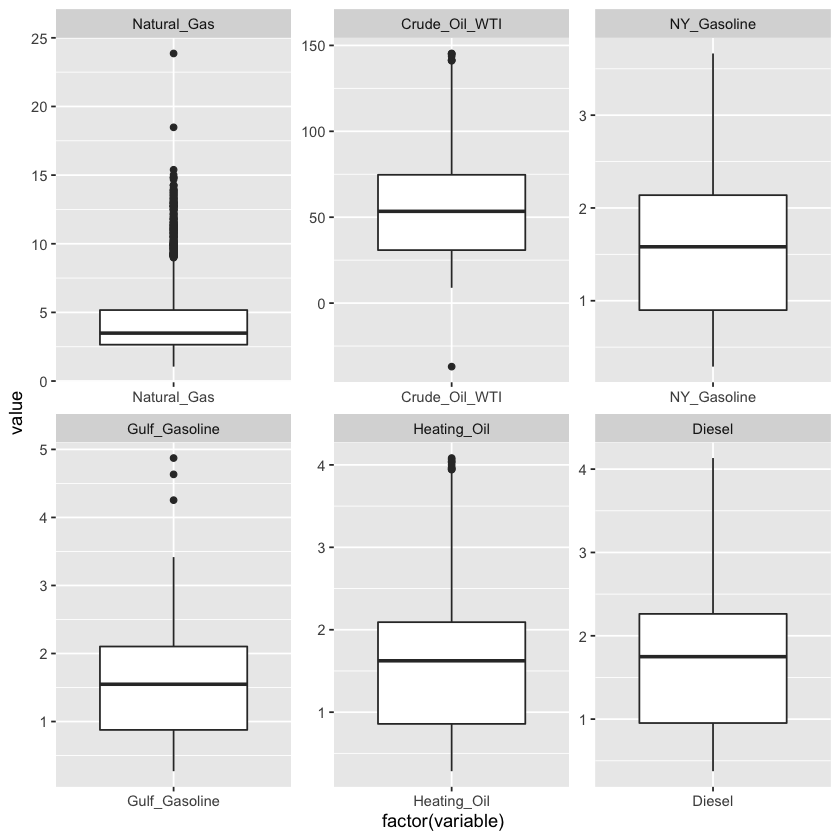

In [183]:
long_dt <- melt(dt, id.vars = c("Date"))
print(head(long_dt))

ggplot(long_dt, aes(factor(variable), value)) + 
geom_boxplot() + 
facet_wrap(~variable, scale="free")

long_dt %>% group_by(as.factor(variable)) %>%
  get_summary_stats(type = "common")

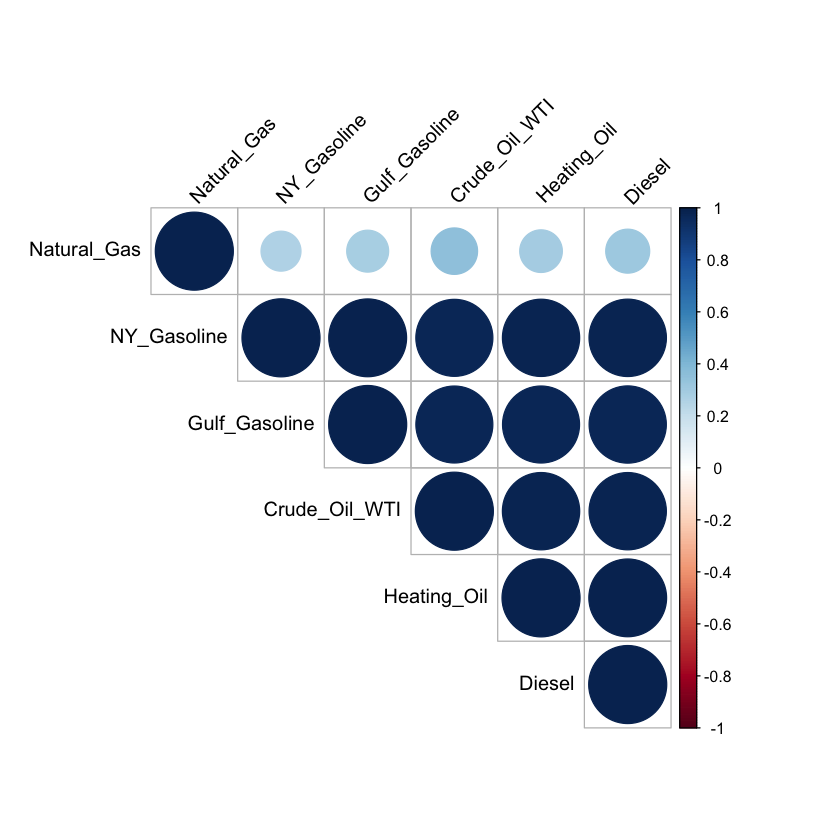

In [184]:
cor_dt <- cor(dt[,-1])
corrplot(cor_dt, type="upper", order="hclust", tl.col="black", tl.srt=45)

We see that this **crude oil WTI metric** had negative prices at one point. This would not let us do log-returns, so we substitute with low value for now. Should be treated more rigorously later on.

In [185]:
dt[dt$Crude_Oil_WTI<0,"Crude_Oil_WTI"]
dt[dt$Date=="2020-04-20","Crude_Oil_WTI"]<-0.01

Crude_Oil_WTI
<dbl>
-36.98


### Log returns

In [186]:
log_ret_dt <- tibble(dt[2:nrow(dt), "Date"])

for (i in 2:(ncol(dt))) {
  var_name <- paste(colnames(dt)[i], "log_ret", sep = "_")
  print(var_name)
  vals <- log(dt[, i]) %>% pull()
  lag_vals <- diff(vals, lag = 1)
  log_ret_dt[var_name] <- lag_vals
}

log_ret_dt[!complete.cases(log_ret_dt), ] #empty

[1] "Natural_Gas_log_ret"
[1] "Crude_Oil_WTI_log_ret"
[1] "NY_Gasoline_log_ret"
[1] "Gulf_Gasoline_log_ret"
[1] "Heating_Oil_log_ret"
[1] "Diesel_log_ret"


Date,Natural_Gas_log_ret,Crude_Oil_WTI_log_ret,NY_Gasoline_log_ret,Gulf_Gasoline_log_ret,Heating_Oil_log_ret,Diesel_log_ret
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


### Summary statistics - Log Returns

        Date    variable value
1 1997-01-07 Natural_Gas  3.82
2 1997-01-08 Natural_Gas  3.80
3 1997-01-09 Natural_Gas  3.61
4 1997-01-10 Natural_Gas  3.92
5 1997-01-13 Natural_Gas  4.00
6 1997-01-14 Natural_Gas  4.01


as.factor(variable),variable,n,min,max,median,iqr,mean,sd,se,ci
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Natural_Gas_log_ret,value,6265,-1.274,1.192,0.000,0.039,0,0.060,0.001,0.001
Crude_Oil_WTI_log_ret,value,6265,-7.513,6.792,0.001,0.026,0,0.137,0.002,0.003
NY_Gasoline_log_ret,value,6265,-1.280,1.077,0.001,0.030,0,0.046,0.001,0.001
Gulf_Gasoline_log_ret,value,6265,-1.718,1.697,0.000,0.032,0,0.061,0.001,0.002
Heating_Oil_log_ret,value,6265,-0.709,0.677,0.000,0.026,0,0.039,0.000,0.001
Diesel_log_ret,value,6265,-0.618,0.576,0.000,0.024,0,0.036,0.000,0.001


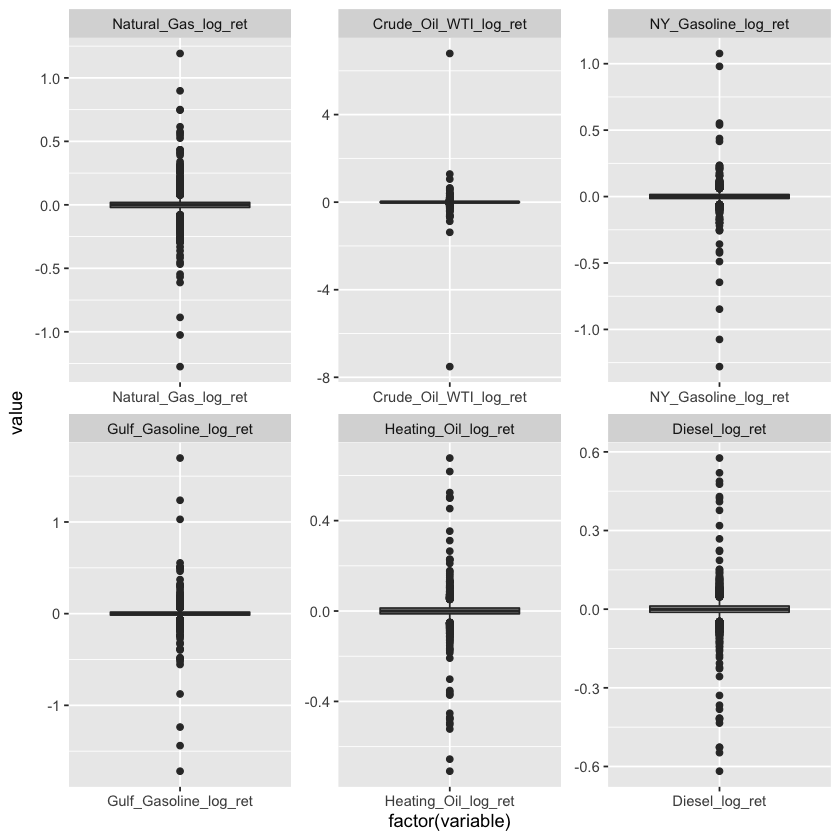

In [187]:
long_log_ret <- melt(log_ret_dt, id.vars = c("Date"))
print(head(long_dt))

ggplot(long_log_ret, aes(factor(variable), value)) + 
geom_boxplot() + 
facet_wrap(~variable, scale="free")

long_log_ret %>% group_by(as.factor(variable)) %>%
  get_summary_stats(type = "common")

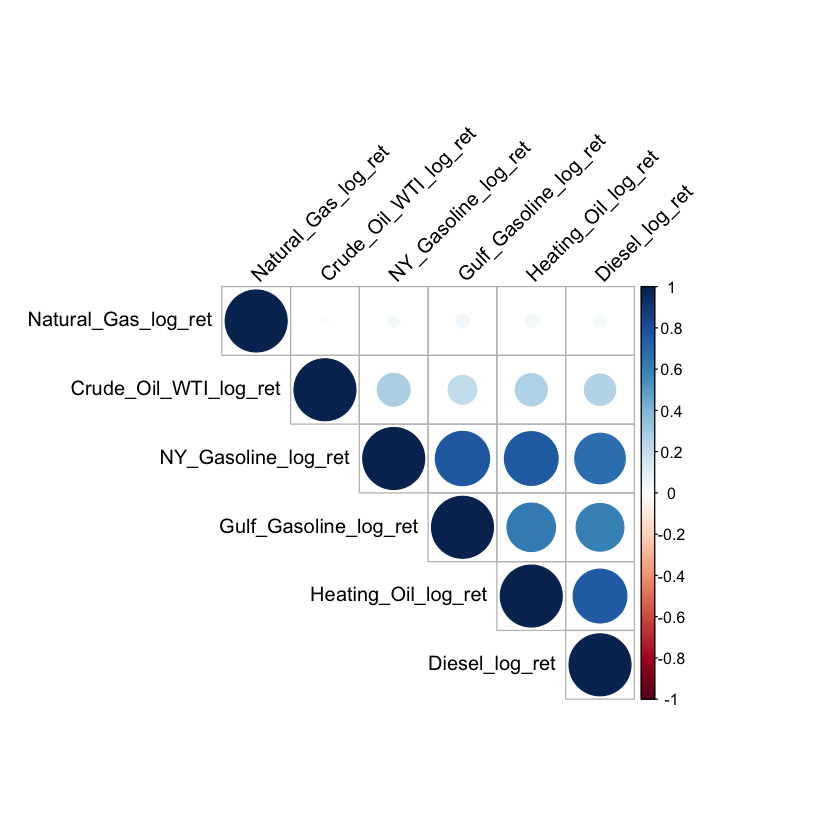

In [188]:
cor_long_dt <- cor(log_ret_dt[,-1])
corrplot(cor_long_dt, type="upper", order="hclust", tl.col="black", tl.srt=45)

### Basic plots

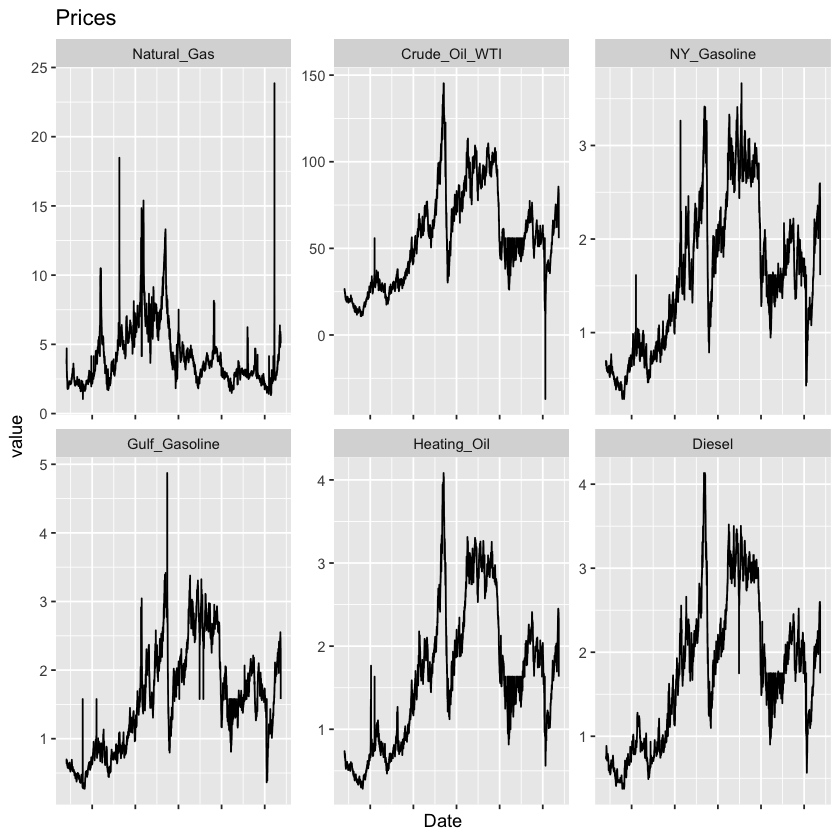

In [189]:
ggplot(long_dt, aes(x = Date, y = value)) +
  geom_line() +
  facet_wrap(~variable, scales = "free") +
  theme(axis.text.x = element_blank()) +
  ggtitle("Prices") +
  geom_vline(xintercept = as.POSIXct("2008-9-15"), color = "Red")

Everything but Natural gas looks very correlated, price data are obviously not stationary, so we transform to log-returns.

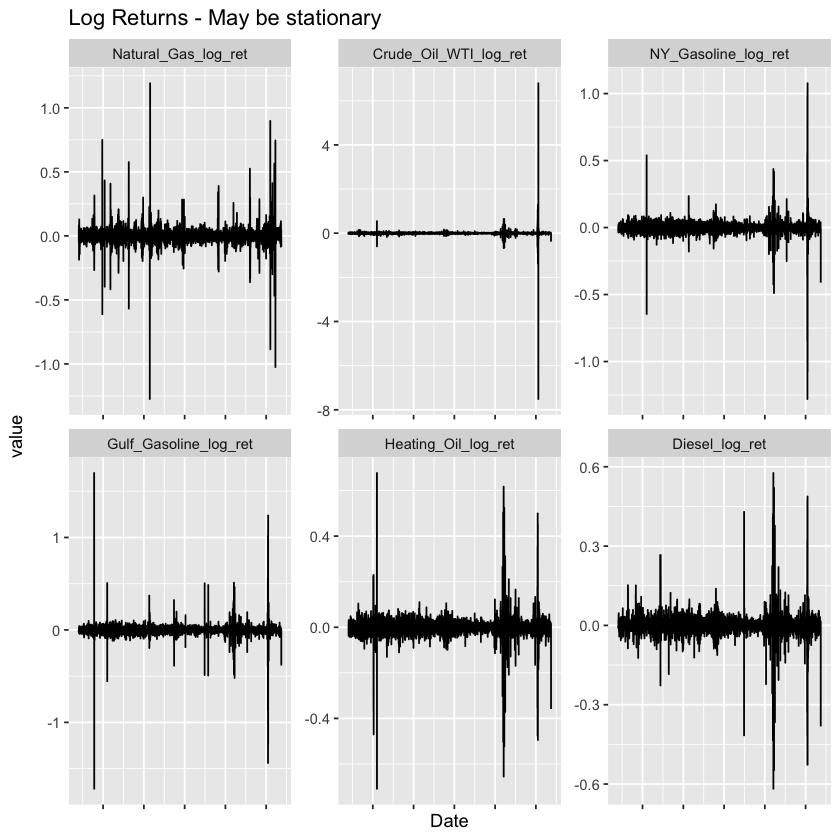

In [190]:
ggplot(long_log_ret, aes(x = Date, y = value)) +
  geom_line() +
  facet_wrap(~variable, scales = "free") +
  theme(axis.text.x = element_blank()) +
  ggtitle("Log Returns - May be stationary")

## Statistical Tests

### Autocorrelation tests

In [191]:
#Natural Gas
model <- lm(Natural_Gas_log_ret ~ I(lagpad(Natural_Gas_log_ret, 1)), data = log_ret_dt)
print("UNIT ROOT TEST")
adf.test(log_ret_dt$Natural_Gas_log_ret) #no unit root
res <- summary(model)$residuals
ar_lm <- lm(res ~ lagpad(res, 1))
print("RESIDUAL AUTOCORRELATION TEST")
summary(ar_lm) #no autocorrelation of residuals

[1] "UNIT ROOT TEST"


Warning message in adf.test(log_ret_dt$Natural_Gas_log_ret):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  log_ret_dt$Natural_Gas_log_ret
Dickey-Fuller = -22.0494, Lag order = 18, p-value = 0.01
alternative hypothesis: stationary


[1] "RESIDUAL AUTOCORRELATION TEST"



Call:
lm(formula = res ~ lagpad(res, 1))

Residuals:
      Min        1Q    Median        3Q       Max 
-1.271962 -0.020418 -0.000058  0.019190  1.192194 

Coefficients:
                    Estimate    Std. Error t value Pr(>|t|)
(Intercept)     0.0000083168  0.0007614560  0.0109   0.9913
lagpad(res, 1) -0.0053355263  0.0126390686 -0.4221   0.6729

Residual standard error: 0.060261 on 6261 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  2.8462e-05,	Adjusted R-squared:  -0.00013125 
F-statistic: 0.17821 on 1 and 6261 DF,  p-value: 0.67293


In [192]:
#Crude Oil
model <- lm(Crude_Oil_WTI_log_ret ~ I(lagpad(Crude_Oil_WTI_log_ret, 1)), data = log_ret_dt)
print("UNIT ROOT TEST")
adf.test(log_ret_dt$Crude_Oil_WTI_log_ret) # no unit root
res <- summary(model)$residuals
ar_lm <- lm(res ~ lagpad(res, 1))
print("RESIDUAL AUTOCORRELATION TEST")
summary(ar_lm) #AR(1) OF RESIDUALS


[1] "UNIT ROOT TEST"


Warning message in adf.test(log_ret_dt$Crude_Oil_WTI_log_ret):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  log_ret_dt$Crude_Oil_WTI_log_ret
Dickey-Fuller = -21.9423, Lag order = 18, p-value = 0.01
alternative hypothesis: stationary


[1] "RESIDUAL AUTOCORRELATION TEST"



Call:
lm(formula = res ~ lagpad(res, 1))

Residuals:
     Min       1Q   Median       3Q      Max 
-7.55960 -0.01534  0.00119  0.01647  3.95287 

Coefficients:
                    Estimate    Std. Error  t value            Pr(>|t|)    
(Intercept)     0.0000085895  0.0015325036   0.0056              0.9955    
lagpad(res, 1) -0.1299893651  0.0125405633 -10.3655 <0.0000000000000002 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.12128 on 6261 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.016871,	Adjusted R-squared:  0.016714 
F-statistic: 107.44 on 1 and 6261 DF,  p-value: < 0.000000000000000222


In [193]:
#NY Gasoline
model <- lm(NY_Gasoline_log_ret ~ I(lagpad(NY_Gasoline_log_ret, 1)), data = log_ret_dt)
print("UNIT ROOT TEST")
adf.test(log_ret_dt$NY_Gasoline_log_ret) # no unit root
res <- summary(model)$residuals
ar_lm <- lm(res ~ lagpad(res, 1))
print("RESIDUAL AUTOCORRELATION TEST")
summary(ar_lm) #AR(1) OF RESIDUALS

[1] "UNIT ROOT TEST"


Warning message in adf.test(log_ret_dt$NY_Gasoline_log_ret):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  log_ret_dt$NY_Gasoline_log_ret
Dickey-Fuller = -17.2913, Lag order = 18, p-value = 0.01
alternative hypothesis: stationary


[1] "RESIDUAL AUTOCORRELATION TEST"



Call:
lm(formula = res ~ lagpad(res, 1))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.940012 -0.015803  0.001133  0.016195  1.097166 

Coefficients:
                    Estimate    Std. Error t value Pr(>|t|)   
(Intercept)     0.0000068083  0.0005511200  0.0124 0.990144   
lagpad(res, 1) -0.0412567697  0.0127189081 -3.2437 0.001186 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.043615 on 6261 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.0016777,	Adjusted R-squared:  0.0015183 
F-statistic: 10.522 on 1 and 6261 DF,  p-value: 0.0011859


In [194]:
#Gulf Gasoline
model <- lm(Gulf_Gasoline_log_ret ~ I(lagpad(Gulf_Gasoline_log_ret, 1)), data = log_ret_dt)
print("UNIT ROOT TEST")
adf.test(log_ret_dt$Gulf_Gasoline_log_ret) # no unit root
res <- summary(model)$residuals
ar_lm <- lm(res ~ lagpad(res, 1))
print("RESIDUAL AUTOCORRELATION TEST")
summary(ar_lm) #AR(1) OF RESIDUALS

[1] "UNIT ROOT TEST"


Warning message in adf.test(log_ret_dt$Gulf_Gasoline_log_ret):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  log_ret_dt$Gulf_Gasoline_log_ret
Dickey-Fuller = -17.8248, Lag order = 18, p-value = 0.01
alternative hypothesis: stationary


[1] "RESIDUAL AUTOCORRELATION TEST"



Call:
lm(formula = res ~ lagpad(res, 1))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.991364 -0.017401  0.001263  0.018243  1.673820 

Coefficients:
                    Estimate    Std. Error t value    Pr(>|t|)    
(Intercept)     0.0000078963  0.0007092934  0.0111      0.9911    
lagpad(res, 1) -0.0655251733  0.0126579268 -5.1766 0.000000233 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.056133 on 6261 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.0042618,	Adjusted R-squared:  0.0041028 
F-statistic: 26.797 on 1 and 6261 DF,  p-value: 0.000000233


In [195]:
#Heating Oil Gasoline
model <- lm(Heating_Oil_log_ret ~ I(lagpad(Heating_Oil_log_ret, 1)), data = log_ret_dt)
print("UNIT ROOT TEST")
adf.test(log_ret_dt$Heating_Oil_log_ret) # no unit root
res <- summary(model)$residuals
ar_lm <- lm(res ~ lagpad(res, 1))
print("RESIDUAL AUTOCORRELATION TEST")
summary(ar_lm) #AR(1) OF RESIDUALS

[1] "UNIT ROOT TEST"


Warning message in adf.test(log_ret_dt$Heating_Oil_log_ret):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  log_ret_dt$Heating_Oil_log_ret
Dickey-Fuller = -20.2928, Lag order = 18, p-value = 0.01
alternative hypothesis: stationary


[1] "RESIDUAL AUTOCORRELATION TEST"



Call:
lm(formula = res ~ lagpad(res, 1))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.490008 -0.013165  0.000384  0.013688  0.671582 

Coefficients:
                  Estimate  Std. Error t value Pr(>|t|)  
(Intercept)     0.00000116  0.00047240  0.0025  0.99804  
lagpad(res, 1) -0.02523654  0.01272642 -1.9830  0.04741 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.037385 on 6261 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.00062767,	Adjusted R-squared:  0.00046805 
F-statistic: 3.9323 on 1 and 6261 DF,  p-value: 0.047411


In [196]:
#Diesel
model <- lm(Diesel_log_ret ~ I(lagpad(Diesel_log_ret, 1)), data = log_ret_dt)
print("UNIT ROOT TEST")
adf.test(log_ret_dt$Diesel_log_ret) # no unit root
res <- summary(model)$residuals
ar_lm <- lm(res ~ lagpad(res, 1))
print("RESIDUAL AUTOCORRELATION TEST")
summary(ar_lm) #no autocorrelation of residuals

[1] "UNIT ROOT TEST"


Warning message in adf.test(log_ret_dt$Diesel_log_ret):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  log_ret_dt$Diesel_log_ret
Dickey-Fuller = -19.4758, Lag order = 18, p-value = 0.01
alternative hypothesis: stationary


[1] "RESIDUAL AUTOCORRELATION TEST"



Call:
lm(formula = res ~ lagpad(res, 1))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.443358 -0.012684  0.000062  0.012587  0.564480 

Coefficients:
                    Estimate    Std. Error t value Pr(>|t|)
(Intercept)     0.0000014492  0.0004373869  0.0033   0.9974
lagpad(res, 1) -0.0184843424  0.0127585562 -1.4488   0.1474

Residual standard error: 0.034614 on 6261 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.00033513,	Adjusted R-squared:  0.00017547 
F-statistic:  2.099 on 1 and 6261 DF,  p-value: 0.14745


Few of these commodities have autocorrelation of residuals, which should be treated by FGLS or using robust standard errors.

## MA(1) Test
Only for Diesel since the others would be similar.
MA is obviously good fit since the data are already differenced (endogenously created)


Call:
arima(x = log_ret_dt$Diesel_log_ret, order = c(0, 0, 1))

Coefficients:
           ma1  intercept
      -0.29297    0.00014
s.e.   0.01169    0.00031

sigma^2 estimated as 0.0011943:  log likelihood = 12192.76,  aic = -24379.52


Call:
arima(x = log_ret_dt$Diesel_log_ret, order = c(1, 0, 0))

Coefficients:
           ar1  intercept
      -0.28510    0.00014
s.e.   0.01223    0.00034

sigma^2 estimated as 0.0011978:  log likelihood = 12183.48,  aic = -24360.97

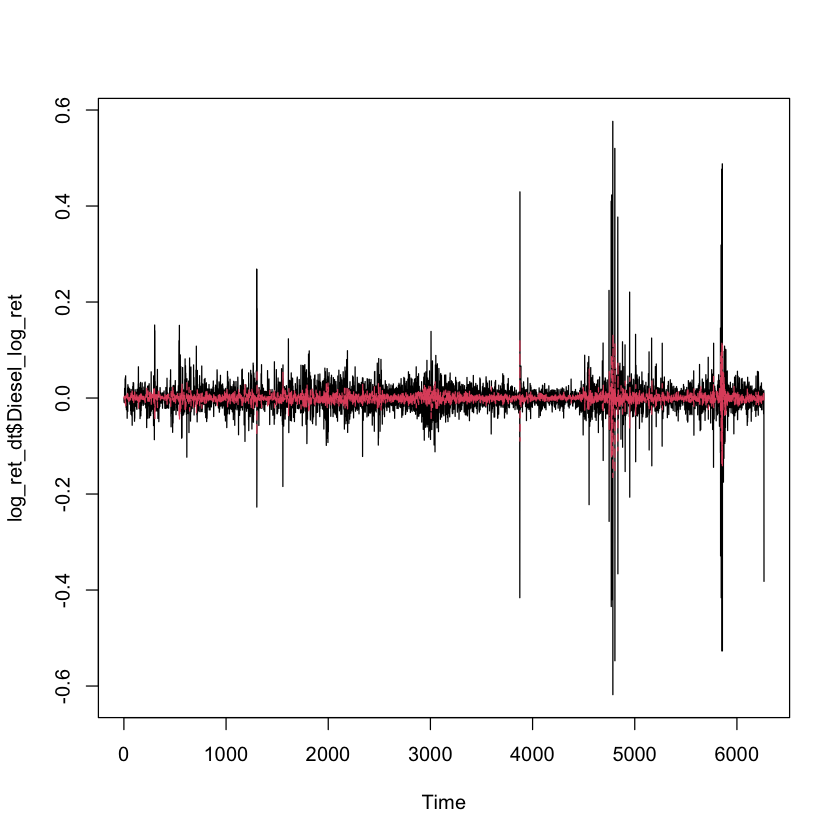

In [197]:
diesel_ma <- arima(log_ret_dt$Diesel_log_ret, order = c(0, 0, 1))
diesel_ma

ts.plot(log_ret_dt$Diesel_log_ret)
points(log_ret_dt$Diesel_log_ret-diesel_ma$residuals, type = "l", col = 2, lty = 2)

arima(log_ret_dt$Diesel_log_ret, order = c(1, 0, 0)) 
#same as summary(model) from before, so I could also use this package for AR testing